In [43]:
import numpy as np
import xarray as xr
from lib import read_xarray, get_not_included_masks
from lib import find_neighbours,get_not_included_masks

In [44]:
def create_nc_mask_NSEO(dep_file,fname_mask_NSEO,plot_dep=False):
    '''
        fonction qui divise le mask (dep_file) en une vingtaine de sous-zones géographiques (nord,sud, nord  + est, etc...)
        et sauvegarde ce nouveau mask en ncdf. 
        in : 
            - dep_file: fichier ncdf contenant le mask du département
            - fname_mask_NSEO: fichier de sortie dans lequel seront stockés les nouveaux masks
        out: le mask avec les sous-zones 
        
        !!! fonction à rendre plus claire !!! 
    '''
    ds_dep    = read_xarray(dep_file) 
    lat1_3,lat2_3 = ds_dep["latitude"].quantile([1/3,2/3])
    lon1_3,lon2_3 = ds_dep["longitude"].quantile([1/3,2/3]) 

    ds_mask = ds_dep.copy().squeeze("id",drop=True) # création d'un dataset contenant les masks N, S, E, O

    latmin_dict = {'nord':float(lat2_3.values),'sud':ds_mask.latitude.values.min()
                   ,'ouest':ds_mask.latitude.values.min(),'est':ds_mask.latitude.values.min()}

    latmax_dict = {'nord':ds_mask.latitude.values.max(),'sud':float(lat1_3.values)
                   ,'ouest':ds_mask.latitude.values.max(),'est':ds_mask.latitude.values.max()}

    lonmin_dict = {'nord':ds_mask.longitude.values.min(),'sud':ds_mask.longitude.values.min()
                   ,'ouest':ds_mask.longitude.values.min(),'est':float(lon2_3.values)}

    lonmax_dict = {'nord':ds_mask.longitude.values.max(),'sud':ds_mask.longitude.values.max()
                   ,'ouest':float(lon1_3.values),'est':ds_mask.longitude.values.max()}

    # definition des masks centraux
    for id_geo in ['nord','sud','est','ouest']:
        ds_mask[id_geo] = ds_mask.mask * 0
        ind    = np.where((ds_mask.latitude>=latmin_dict[id_geo]) & (ds_mask.latitude<=latmax_dict[id_geo])
                 & (ds_mask.longitude >= lonmin_dict[id_geo]) & (ds_mask.longitude<=lonmax_dict[id_geo]))
        ds_mask[id_geo].values[ind] = 1
        ds_mask[id_geo].values[np.isnan(ds_dep.squeeze("id").mask.values)] = np.nan

    # definition des masks croises
    dict_id_geo_id = {}
    i=0
    for var1 in ['est','ouest']:
        for var2 in ['nord','sud']: 
            id_geo = var2 + '-'+var1
            ds_mask[id_geo] = ds_mask[var1]* ds_mask[var2] # egal a 1 quand les deux valent 1, sinon 0 
            dict_id_geo_id[id_geo]  = str(i)
            i+=1
    
    # definition des milieux (nord-centre, sud-centre) et (est-centre, ouest-centre) 
    id_geo_extremitees={
        'nord-centre' : ['nord-est','nord-ouest'],
        'sud-centre' : ['sud-est','sud-ouest'],
        'est-centre' : ['nord-est','sud-est'],
        'ouest-centre':['nord-ouest','sud-ouest']
    }

    for id_geo in id_geo_extremitees.keys():
        id_ref = id_geo.split('-')[0]
        ds_mask[id_geo] = ds_mask[id_ref] - ds_mask[id_geo_extremitees[id_geo][0]] - ds_mask[id_geo_extremitees[id_geo][1]] 
        dict_id_geo_id[id_geo]  = str(i)

        i+=1
    # import sys;sys.exit()    
    # definition du centre 
    id_geo = 'centre'
    ds_mask[id_geo] = ds_mask.mask.copy()
    ds_mask[id_geo].values[(ds_mask.nord ==1 ) + (ds_mask.sud ==1 ) 
                            + (ds_mask.est ==1 ) + (ds_mask.ouest ==1 )] = 0
    dict_id_geo_id[id_geo]  = str(i)

    # les id des 9 masques centraux
    lst_ini_id_geo = [key for key in dict_id_geo_id if len(key.split('+'))==1 and key not in ['nord','est','sud','ouest']]
    dict_id_geo_id["departement"] = '+'.join([dict_id_geo_id[key] for key in dict_id_geo_id if len(key.split('+'))==1 and key not in ['nord','est','sud','ouest']])

    # on met à jour les id de nord,est,ouest,sud 
    dict_id_geo_id['nord']  = '+'.join([dict_id_geo_id['nord-est'],dict_id_geo_id['nord-centre'], dict_id_geo_id['nord-ouest']])
    dict_id_geo_id['sud']   = '+'.join([dict_id_geo_id['sud-est'],dict_id_geo_id['sud-centre'], dict_id_geo_id['sud-ouest']])
    dict_id_geo_id['est']   = '+'.join([dict_id_geo_id['nord-est'], dict_id_geo_id['est-centre'], dict_id_geo_id['sud-est']])
    dict_id_geo_id['ouest'] = '+'.join([dict_id_geo_id['nord-ouest'], dict_id_geo_id['ouest-centre'], dict_id_geo_id['sud-ouest']])

    # Nord + Est et Nord + ouest (idem pour sud)
    for var1 in ['nord','sud']:
        for var2 in ['est','ouest']: 
            id_geo = var1 + '+'+var2
            ds_mask[id_geo] = ds_mask[var1].copy()
            ds_mask[id_geo].values[ds_mask[var2].values==1] = 1
            dict_id_geo_id[id_geo] = '+'.join([dict_id_geo_id[var1],dict_id_geo_id[var2]])

    # centre + nord (resp + sud, + est, + ouest)
    for var in ['nord','sud','est','ouest']:
        id_geo = 'centre+'+var
        ds_mask[id_geo] = ds_mask['centre'].copy()
        ds_mask[id_geo].values[ds_mask[var].values==1] = 1
        dict_id_geo_id[id_geo] = '+'.join([dict_id_geo_id['centre'],dict_id_geo_id[var]])

    # tout le mask sauf certaines zones ('tout sauf tata')
    for var in ['nord','sud','est','ouest']:
        id_geo = 'tout-'+var
        ds_mask[id_geo] = ds_mask.mask.copy() - ds_mask[var].values
        dict_id_geo_id[id_geo] = '+'.join([dict_id_geo_id[key] for key in lst_ini_id_geo if var not in key])

    # save 
    ds_out = xr.Dataset()

    for i,keys in enumerate(ds_mask.data_vars):
        if keys =='mask':
            ds_temp = ds_mask[keys].expand_dims("id").assign_coords(id=[dict_id_geo_id['departement']]).rename("mask")
        else:
            ds_temp = ds_mask[keys].expand_dims("id").assign_coords(id=[dict_id_geo_id[keys]]).rename("mask")
        ds_out = xr.merge([ds_out,ds_temp])

    # on rajoute une variable contenant les id géographiques (id_geo)
    dict_id_id_geo = dict(zip(dict_id_geo_id.values(),dict_id_geo_id.keys())) # les values deviennent les keys.
    list_id_geo = [dict_id_id_geo[id] for id in ds_out.id.values] 
    ds_int = xr.Dataset({'id_geo':('id',list_id_geo),'id':ds_out.id.values})
    ds_out = ds_out.merge(ds_int)
    ds_out.to_netcdf(fname_mask_NSEO)
    if plot_dep:
        import matplotlib.pyplot as plt
        fig,axes = plt.subplots(nrows=7,ncols =4,figsize=(10,25))
        ax = axes.flat
        for imask_id,id in enumerate(ds_out.id.values): 
            ds_out.mask.sel(id=id).plot.imshow(ax=ax[imask_id])
            ax[imask_id].set_title(id+'\n'+ds_out.id_geo.sel(id=id).values.tolist())
        fig.tight_layout()
        
    return ds_out

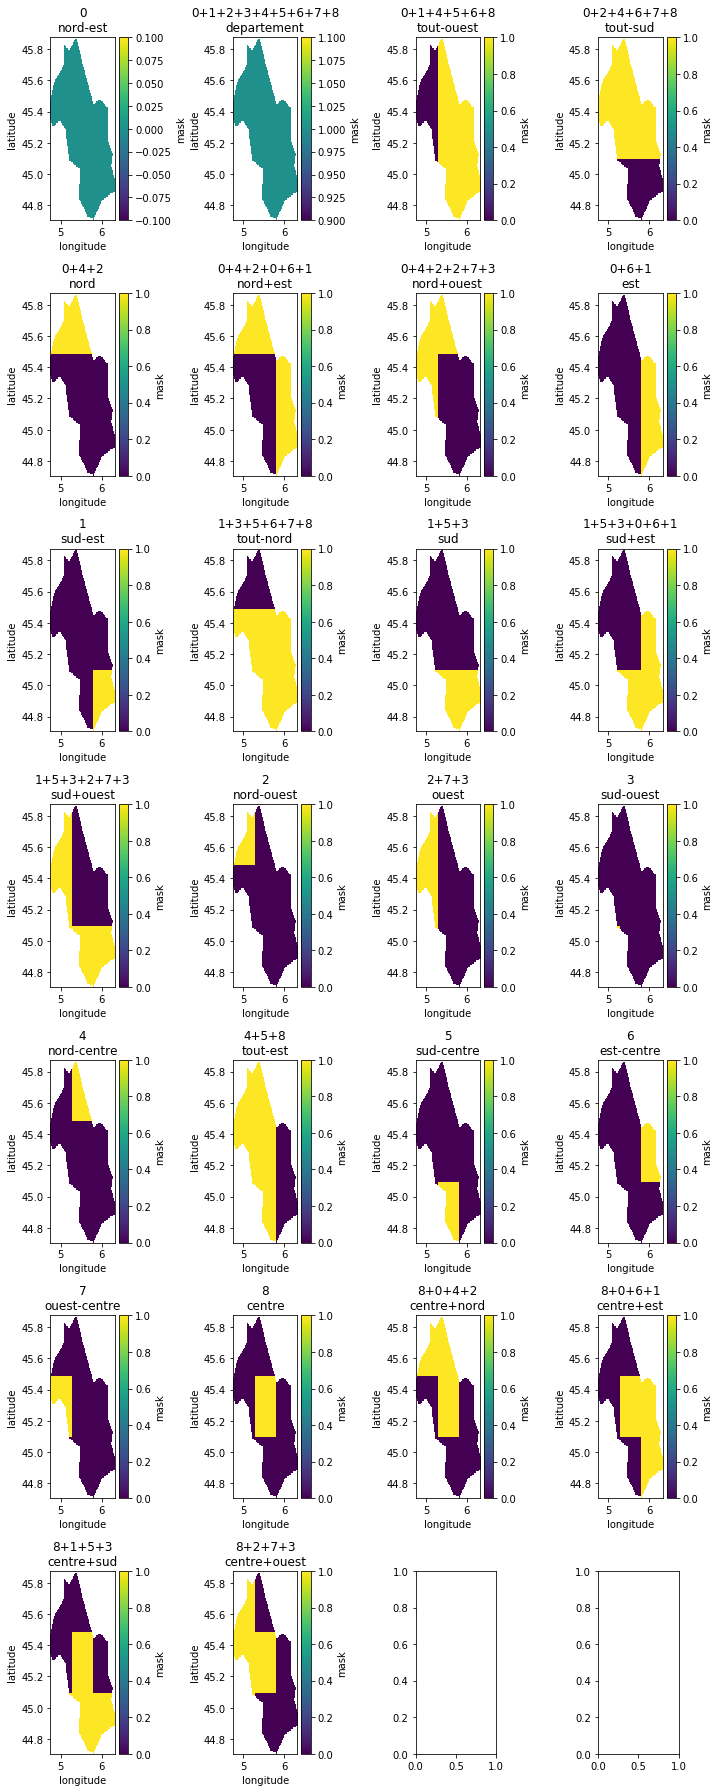

In [42]:
dep_id = '38'
if   dep_id == '38': dep = 'FRK24'
elif dep_id == '41': dep = 'FRB05'
elif dep_id == "34": dep = 'FRJ13'
elif dep_id == '29': dep = "FRH02"
dir_mask  = '../GeoData/nc_departement/'
dep_file  = dir_mask + dep +'.nc' 
fname_out = '../GeoData/zones_sympo_multiples/'+ dep_id+'_'+dep+'_mask_NSEO.nc'

ds_mask = create_nc_mask_NSEO(dep_file,fname_out,plot_dep=True)


In [24]:
# ds_mask.id.values
zone = '0+6+1'
listMasksNew = ds_mask.id.values
lst_mask_not_included_finale,  lst_mask_strict_included = get_not_included_masks(ds_mask.mask.sel(id=zone) ,listMasksNew,ds_mask,flag_strictly_included=False)

print(ds_mask.id_geo.sel(id=zone).values)
# print('not included',ds_mask.id_geo.sel(id=lst_mask_not_included_finale).values)
# print('included',ds_mask.id_geo.sel(id=lst_mask_strict_included).values)



est
not included ['nord-ouest' 'ouest' 'sud-ouest' 'nord-centre' 'tout-est' 'sud-centre'
 'ouest-centre' 'centre' 'centre+ouest']
included ['nord-est' 'est' 'sud-est' 'est-centre']


In [27]:
zone = '0+4+2'
mask_ref = ds_mask.sel(id=zone)
listMasks = [ds_mask.sel(id=zone) for zone in ds_mask.id.values]
voisin = find_neighbours(mask_ref,listMasks)
print(ds_mask.id_geo.sel(id=zone).values)
print(ds_mask.id_geo.sel(id=voisin).values)
# print('not included',ds_mask.id_geo.sel(id=lst_mask_not_included_finale).values)

nord
['nord-est' 'departement' 'tout-ouest' 'tout-sud' 'nord+est' 'nord+ouest'
 'est' 'sud+est' 'sud+ouest' 'nord-ouest' 'ouest' 'nord-centre' 'tout-est'
 'centre+nord' 'centre+est' 'centre+ouest']


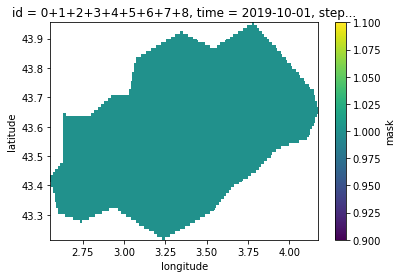

In [41]:
ds_mask.sel(id= ds_mask.id[ds_mask.id_geo == 'departement']).mask.plot()

